# Predictive detection of RMA devices

## What is predictive detection of RMA?

Let us start from the concept of RMA: RMA stands for Return Merchandise Authorization. It's a formal agreement between a seller (usually a retailer) and a customer that allows the return of a product.

In multiple business the RMA process is something that could generate unexpected expenses as this generally involved replacement of a product. Specifically in our business GPS Tracking, this is not different. I'll be focused over the world of GPS devices to predict when devices can go over the RMA process. For this, we'll be considering aggregated telemetry values captured mainly focused on potential problems identified in our GPS industry.


## Package imports

In [157]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import auc as skl_auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as PipelineImb

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from category_encoders import TargetEncoder
from sklearn.inspection import permutation_importance


import time

warnings.filterwarnings('ignore')

## Data Description

The analysis will be based on 3 different files consisting of:

- **devices_active.csv**: This file consist of 2000 records containing information for active devices working as expected without known issues.
- **devices_rma.csv**: It consist of 647 records with devices processed as RMA. In order to mark those devices as RMA, this was necessary to perform a sequence of thoubleshoting steps.
- **troubleshooting_cases.csv**: This is a generated reporting from Sales Force platform where are registered cases reported from our customers. Some cases are related to devices by including the ESN or IMEI.

## Data Understanding

### devices_active.csv & devices_rma.csv structure:

*Those files contains the same structure*

- companyId: Internal identifier for the account related with the devices
- unitId: Device identifier
- imei: IMEI registered in the system for this devices
- esn: Serial number
- manufacturer: Name of the manufacturer
- unitType: Classification for the device
- version: Devices model
- isRMA: Boolean indicating if device is marked as RMA
- liveAgeDays: Duration in days for the devices being active in the platform
- HDOPQuality: Average events received with HDOPQuality > 2
- ExcessiveEvents: Average events received at server level from device. This evaluates the maximum events the device is supposed to transmit
- LowBattery: Average events received at server level identified as "low battery"
- IgnitionOnEventsAbnormal: When a device reports more than 50 times per day and the ignitions received is higher than 15% of total. This is an average value. 
- PowerDisconnect: Average events received at server level identified as "power disconnected"
- LowSatellites: Average occurencies When this has being determined the amount of low satellites is present more than 15% of total events.
- DailyOdometerExceeded: Average accumulated distance (Odometer in miles) reported exceeding a distance considering average speed for a vehicle
- WirelessSignal: When the average signal strengh is lower than 10. This is an average.
- MaintenanceLimitExceeded: This is an event generated for devices where the manufacturer is "Calamp". Refers to an event generated when device is reporting the same event more than 100 times during a day. This is a average of occurrences for this event
- LateEvents: When the events arriving late to server is higher than 10% compared with the total events. This is an average.
- CommLost: This is a percentage, validating when commLost events are greater than 10% of total events received
- DailyEngineHoursExceeded: When this is detected the engineHours reported are higher than 24 hours. This is an average of the engine hours reported

### troubleshooting_cases.xlsx

*From this file, we are interested to count the occurrencies of a device being reported on cases. We'll be lookin for the totalCases.*

- PM Account ID: Identifier of this account over the internal company's CRM
- IMEI / SN: Included the serial or IMEI of devices included into the case
- Account Name: Name of the account in our platform
- Subject: Title for the case
- Case Number: Auto generated value from SalesForce identifying the case
- Status: Current status for the case
- Number of Devices Impacted: Devices with the same situation reported in the case
- Category: Classification for the case
- SubCategory: Subclassification for the case
- Return Status: Used to trace when devices must be returned to us. This shows the status of return 
- Open: Boolean: Boolean indicator when case is opened
- Closed: Boolean indicator when case is closed

### Devices & RMA DataSet

In [5]:
# Active devices
devices_active = pd.read_csv('data/devices_active.csv')

In [7]:
# Devices marked as RMA
devices_rma = pd.read_csv('data/devices_rma.csv')

In [9]:
devices_rma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647 entries, 0 to 646
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   companyId                 647 non-null    int64  
 1   unitId                    647 non-null    int64  
 2   imei                      642 non-null    object 
 3   esn                       647 non-null    object 
 4   manufacturer              647 non-null    object 
 5   unitType                  647 non-null    object 
 6   version                   647 non-null    object 
 7   isRMA                     647 non-null    int64  
 8   liveAgeDays               647 non-null    int64  
 9   HDOPQuality               647 non-null    float64
 10  ExcessiveEvents           647 non-null    float64
 11  LowBattery                647 non-null    float64
 12  IgnitionOnEventsAbnormal  647 non-null    float64
 13  PowerDisconnect           647 non-null    float64
 14  LowSatelli

#### Concatenating active and RMA devices

In [11]:
# As devices and RMA csv contains the same structure, we are concatenating those datasets
devices = pd.concat([devices_active, devices_rma], axis=0)
devices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2647 entries, 0 to 646
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   companyId                 2647 non-null   int64  
 1   unitId                    2647 non-null   int64  
 2   imei                      2617 non-null   object 
 3   esn                       2647 non-null   object 
 4   manufacturer              2647 non-null   object 
 5   unitType                  2647 non-null   object 
 6   version                   2647 non-null   object 
 7   isRMA                     2647 non-null   int64  
 8   liveAgeDays               2647 non-null   int64  
 9   HDOPQuality               2647 non-null   float64
 10  ExcessiveEvents           2647 non-null   float64
 11  LowBattery                2647 non-null   float64
 12  IgnitionOnEventsAbnormal  2647 non-null   float64
 13  PowerDisconnect           2647 non-null   float64
 14  LowSatellites 

#### Looking for missing values over Device DataSet

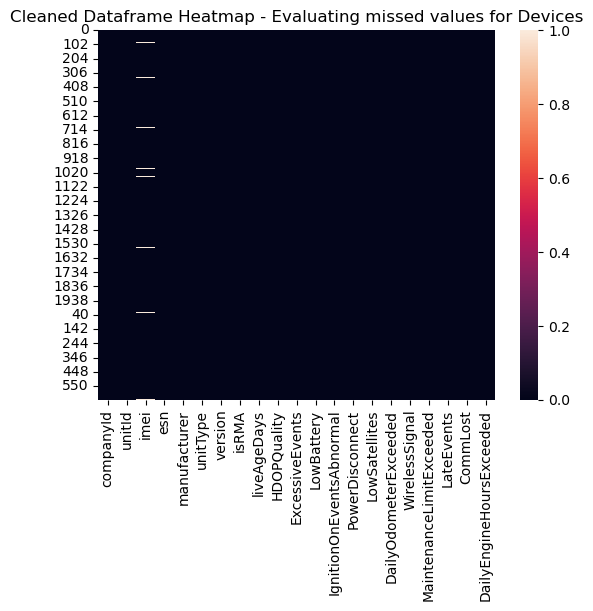

In [13]:
ax = sns.heatmap(
	devices.isna()
)
ax.set_title("Cleaned Dataframe Heatmap - Evaluating missed values for Devices")
plt.show()

In [15]:
# Identifying missed values for IMEI
devices[devices['imei'].isna()]

,companyId,unitId,imei,esn,manufacturer,unitType,version,isRMA,liveAgeDays,HDOPQuality,...,LowBattery,IgnitionOnEventsAbnormal,PowerDisconnect,LowSatellites,DailyOdometerExceeded,WirelessSignal,MaintenanceLimitExceeded,LateEvents,CommLost,DailyEngineHoursExceeded
89,25343,200088184,NaN,2B2CJHPN,VidFleet,VidFleet,360,0,916,69.332694,...,0.0,0.000000,0.000000,0.000000,0.000000e+00,0,0.0,0.000000,0.000000,0.0
170,24928,200087722,NaN,2B2CJHMP,VidFleet,VidFleet,360,0,1004,52.171910,...,0.0,0.000000,2.857143,0.000000,2.536201e+03,0,0.0,0.000000,0.000000,0.0
199,25343,200088178,NaN,2B2CJHJ0,VidFleet,VidFleet,360,0,916,54.169701,...,0.0,5.263158,2.181818,0.000000,0.000000e+00,0,0.0,0.000000,0.000000,0.0
339,23783,200088491,NaN,6B301T7V,VidFleet,VidFleet,4K,0,885,33.515695,...,0.0,0.000000,0.000000,0.000000,0.000000e+00,0,0.0,0.000000,0.000000,0.0
398,25073,200087883,NaN,2B2CJHMU,VidFleet,VidFleet,360,0,977,68.131370,...,0.0,0.000000,0.000000,0.000000,0.000000e+00,0,0.0,21.705947,0.000000,0.0
437,24558,200088119,NaN,6B301LYS,VidFleet,VidFleet,4K,0,930,40.674999,...,0.0,6.005396,0.000000,0.000000,2.696239e+05,0,0.0,0.000000,0.000000,0.0
553,23783,200088490,NaN,6B301T7J,VidFleet,VidFleet,4K,0,885,46.325132,...,0.0,0.000000,0.000000,0.000000,0.000000e+00,0,0.0,0.000000,0.000000,0.0
560,25361,200088250,NaN,6B301SV1,VidFleet,VidFleet,4K,0,900,39.043888,...,0.0,0.000000,0.000000,0.000000,0.000000e+00,0,0.0,0.000000,0.000000,0.0
697,25343,200088194,NaN,2B2DB3BW,VidFleet,VidFleet,360,0,916,52.553926,...,0.0,0.000000,1.225490,0.000000,1.715489e+06,0,0.0,95.088158,0.000000,0.0
802,25361,200088358,NaN,6B301SWA,VidFleet,VidFleet,4K,0,890,38.149880,...,0.0,5.479452,0.000000,0.000000,0.000000e+00,0,0.0,0.000000,0.000000,0.0


##### Filling empty IMEI with ESN as this could be used as identifier

In [17]:
devices['imei'] = devices['imei'].fillna(devices["esn"])

##### Re-evaluating missed values using heatmap

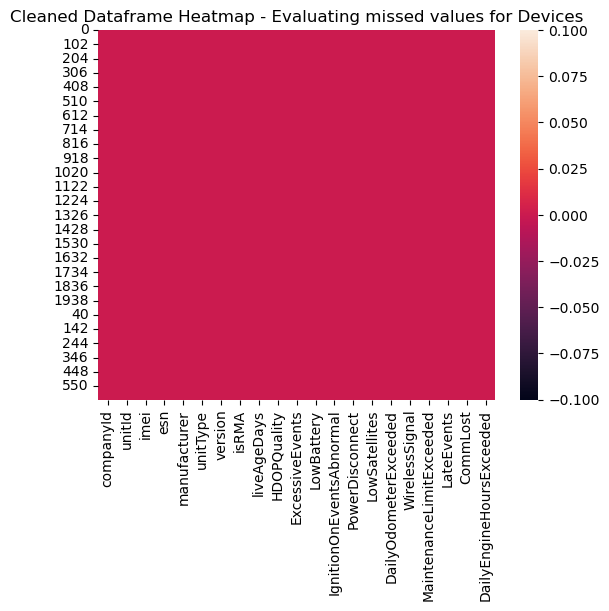

In [19]:
ax = sns.heatmap(
	devices.isna()
)
ax.set_title("Cleaned Dataframe Heatmap - Evaluating missed values for Devices")
plt.show()

### Troubleshooting Cases - DataSet

In [21]:
# Troubleshooting cases
cases = pd.read_excel('data/troubleshooting_cases.xlsx')
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12136 entries, 0 to 12135
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PM Account ID               8260 non-null   object 
 1   IMEI / SN                   10188 non-null  object 
 2   Account Name                12061 non-null  object 
 3   Subject                     12083 non-null  object 
 4   Case Number                 12136 non-null  int64  
 5   Status                      12136 non-null  object 
 6   Number of Devices Impacted  12106 non-null  float64
 7   Category                    12136 non-null  object 
 8   SubCategory                 12131 non-null  object 
 9   Return Status               1354 non-null   object 
 10  Open                        12136 non-null  bool   
 11  Closed                      12136 non-null  bool   
dtypes: bool(2), float64(1), int64(1), object(8)
memory usage: 972.0+ KB


In [23]:
cases.sample(15)

,PM Account ID,IMEI / SN,Account Name,Subject,Case Number,Status,Number of Devices Impacted,Category,SubCategory,Return Status,Open,Closed
7697,21842,4675104261 - J44_x000D_\n\t_x000D_\n4675104169...,"Randall Jason Hyatt, Inc",gps troubleshoot,564340,Resolved,2.0,GPS Troubleshooting,Device(s) Offline,NaN,False,True
11716,NaN,88B120350008,Best Office Group,Device not working,590048,Resolved,1.0,GPS Troubleshooting,Input/Output Issues,NaN,False,True
3410,26869,6B3017Y0,247 Inc,Vidfleet sound alerts,736368,Resolved,1.0,Video Troubleshooting,Config Changes,NaN,False,True
1254,21803,4672034797_x000D_\n4672034824_x000D_\n46720348...,D&B Agro-Systems,These units are installed on trailers with no ...,544570,Resolved,14.0,GPS Troubleshooting,Device(s) Offline,NaN,False,True
3827,NaN,NaN,Advanced Plumbing Systems,Device Troubleshooting,498282,Resolved,1.0,GPS Troubleshooting,Device(s) Offline,NaN,False,True
2403,28022,015425002478420,Advance Lawn Service,Ping not working,634718,Resolved,1.0,GPS Troubleshooting,Other,NaN,False,True
6861,3674,6B301SR4_x000D_\n\t_x000D_\n4674881048,Maclaskey Oilfield Services,Unit 0835 camera installation,535712,Resolved,2.0,Video Troubleshooting,Other,NaN,False,True
11753,4724,015425001663410,Mark Hildebrandt,GPS Not reporting,583063,Resolved,1.0,GPS Troubleshooting,Other,NaN,False,True
6819,28462,6B301ETV_x000D_\n6B301ERN,Central Iowa Fencing c/o USCC,Turn on Camera Event - Smoking,728142,Resolved,2.0,Video Troubleshooting,Config Changes,NaN,False,True
5518,22721,6B301K40,Above the Rest Garage Door Repair,chat cloud Above the Rest Garage Door Repair,590965,Resolved,1.0,Video Troubleshooting,Other,NaN,False,True


#### Removing Empty values

In [25]:
# We are not interested in empty values as this will be used to find a relation with devices DataSet
cases = cases[cases['IMEI / SN'].notnull()]

#### Obtaining the totalCases per device

In [27]:
# Function to lookup ESN or IMEI in cases dataset to find amount of cases
def getTotalCases(row):    
  valueToReview = row['imei'] + "|" + row['esn']
  filtered_df = cases[cases['IMEI / SN'].str.contains(valueToReview, case=False, regex=True)]
  return filtered_df.shape[0]

In [29]:
# Apply function to set the total cases per device
devices['totalCases'] = devices.apply(getTotalCases, axis=1)

In [31]:
# Information over new device with new totalCases column added
devices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2647 entries, 0 to 646
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   companyId                 2647 non-null   int64  
 1   unitId                    2647 non-null   int64  
 2   imei                      2647 non-null   object 
 3   esn                       2647 non-null   object 
 4   manufacturer              2647 non-null   object 
 5   unitType                  2647 non-null   object 
 6   version                   2647 non-null   object 
 7   isRMA                     2647 non-null   int64  
 8   liveAgeDays               2647 non-null   int64  
 9   HDOPQuality               2647 non-null   float64
 10  ExcessiveEvents           2647 non-null   float64
 11  LowBattery                2647 non-null   float64
 12  IgnitionOnEventsAbnormal  2647 non-null   float64
 13  PowerDisconnect           2647 non-null   float64
 14  LowSatellites 

In [33]:
devices.sample(5)

,companyId,unitId,imei,esn,manufacturer,unitType,version,isRMA,liveAgeDays,HDOPQuality,...,IgnitionOnEventsAbnormal,PowerDisconnect,LowSatellites,DailyOdometerExceeded,WirelessSignal,MaintenanceLimitExceeded,LateEvents,CommLost,DailyEngineHoursExceeded,totalCases
1965,6685,200085613,68B121120258,68B121120258,Geometris,68 Series,68 Series,0,667,94.478710,...,0.000000,2.7500,0.0,0.0,0,0.0,0.000000,0.0,0.0,0
42,6379,200065566,68B120040369,68B120040369,Geometris,68 Series,68 Series,0,667,72.097717,...,6.113868,0.0000,0.0,0.0,0,0.0,0.000000,0.0,0.0,0
1285,5251,200063720,88X113630008,88X113630008,Geometris,80 Series,88,0,843,73.519505,...,0.000000,1.2000,0.0,0.0,0,0.0,17.294901,0.0,0.0,3
316,6374,200099649,865640068899464-032124181439,4675413461-032124181439,CalAmp,32 - bit,LMU2630 CAT_M,1,465,0.000000,...,5.221932,0.0000,0.0,0.0,0,0.0,0.000000,0.0,0.0,0
279,26027,200089430,866626031286383-041124154316,6B301VQK-041124154316,VidFleet,VidFleet,4K,1,657,54.085777,...,0.000000,1.3125,0.0,0.0,0,0.0,0.000000,0.0,0.0,0


### How balanced is the data?

Text(0.5, 1.0, 'RMA Status - Proportion')

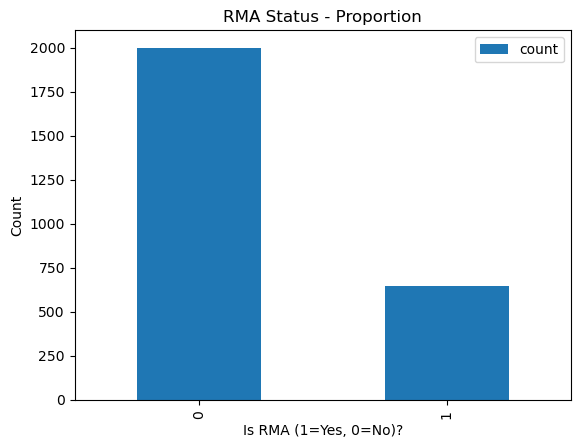

In [35]:
categories = devices['isRMA'].unique()
counts = devices['isRMA'].value_counts()

newDf = pd.DataFrame({ 'class': categories, 'count': counts })
newDf.plot(x="class", y="count", kind="bar")

plt.xlabel("Is RMA (1=Yes, 0=No)?")
plt.ylabel("Count")
plt.title('RMA Status - Proportion')

### Finding Correlations

#### Evaluating correlation

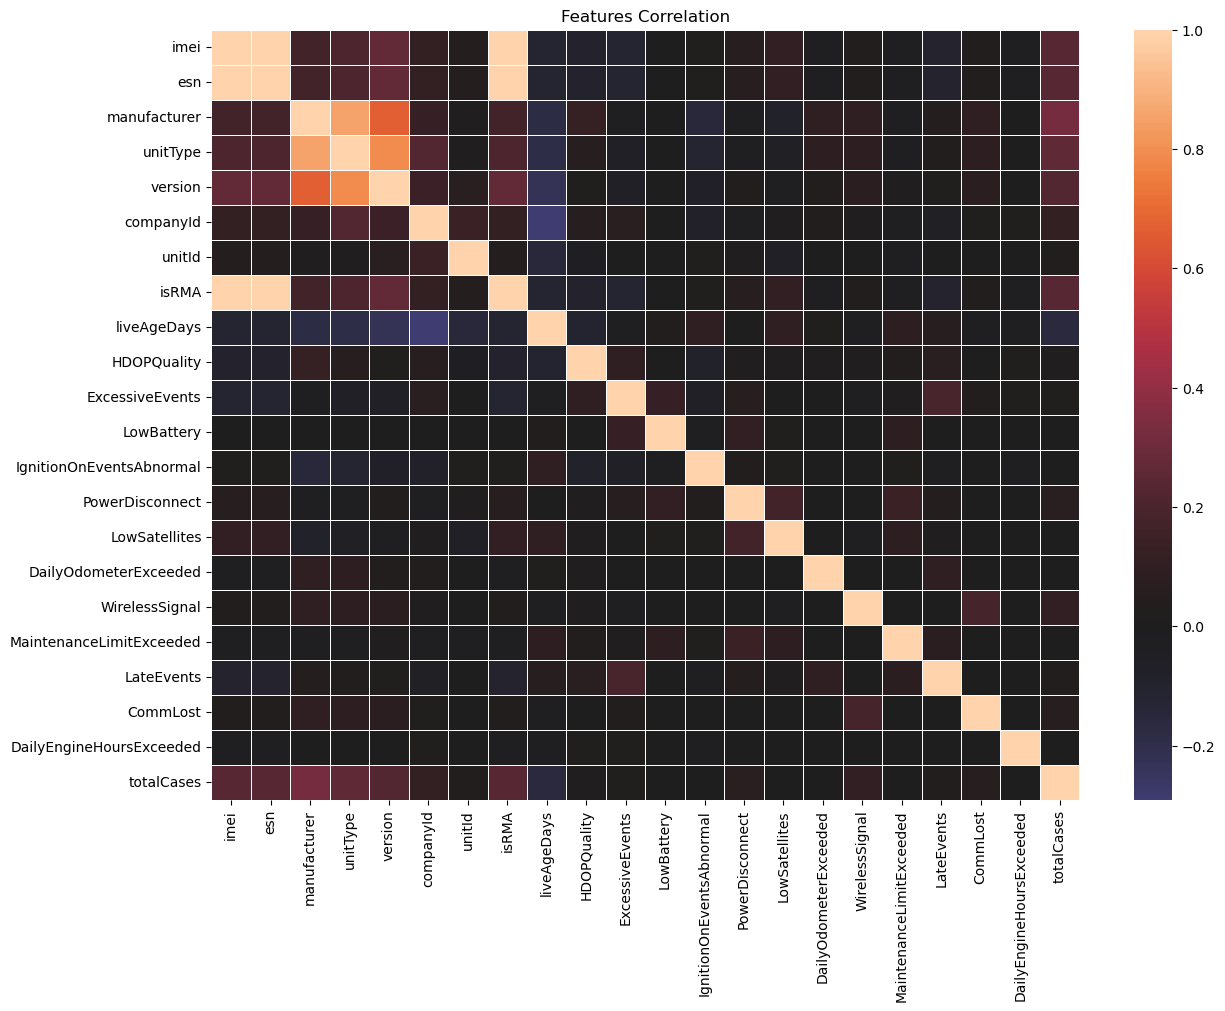

In [37]:
categorical_columns = devices.select_dtypes(include=object).columns
non_categorical_columns = devices.drop(categorical_columns, axis=1)

target_encoder = TargetEncoder()
correlations = pd.concat([
    target_encoder.fit_transform(devices[categorical_columns] , devices["isRMA"]), 
    non_categorical_columns
], axis = 1).corr()


sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(
    correlations, 
    center = 0, 
    linewidth = .5, 
    annot = False
).set(title='Features Correlation');


#### Deleting unnecessary features

In [39]:
df = devices.copy()

# Removing identifier features
df = df.drop(['companyId', 'unitId', 'imei', 'esn'], axis = 1)

# Removing features with high correlation
df = df.drop(['manufacturer', 'unitType'], axis = 1)

#### Evaluating correlation after removal

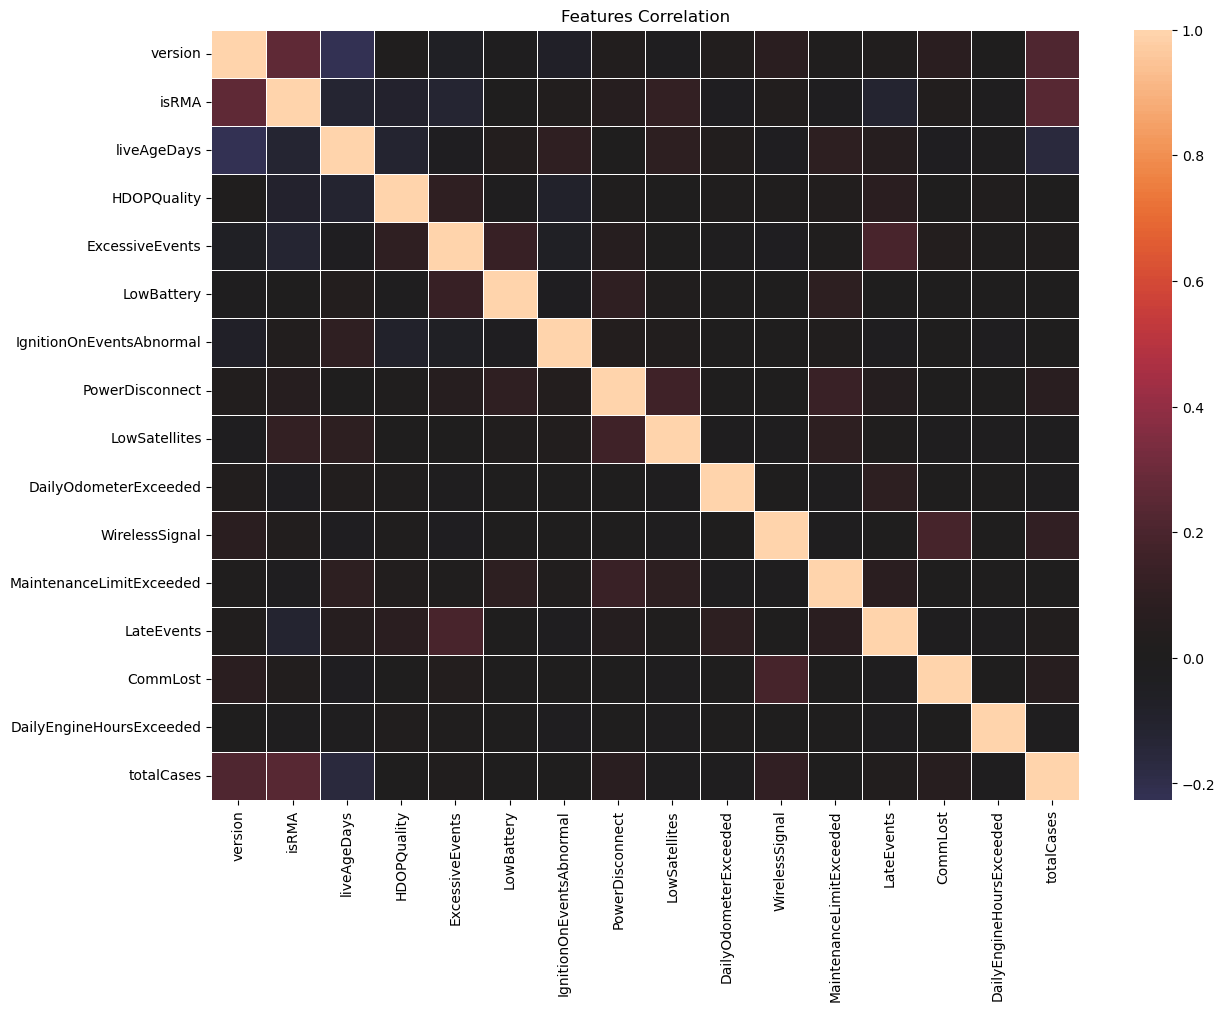

In [41]:
categorical_columns = df.select_dtypes(include=object).columns
non_categorical_columns = df.drop(categorical_columns, axis=1)

target_encoder = TargetEncoder()
correlations = pd.concat([
    target_encoder.fit_transform(df[categorical_columns] , df["isRMA"]), 
    non_categorical_columns
], axis = 1).corr()


sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(
    correlations, 
    center = 0, 
    linewidth = .5, 
    annot = False
).set(title='Features Correlation');

## Finding the best model

#### Choosing Features and Target

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2647 entries, 0 to 646
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   version                   2647 non-null   object 
 1   isRMA                     2647 non-null   int64  
 2   liveAgeDays               2647 non-null   int64  
 3   HDOPQuality               2647 non-null   float64
 4   ExcessiveEvents           2647 non-null   float64
 5   LowBattery                2647 non-null   float64
 6   IgnitionOnEventsAbnormal  2647 non-null   float64
 7   PowerDisconnect           2647 non-null   float64
 8   LowSatellites             2647 non-null   float64
 9   DailyOdometerExceeded     2647 non-null   float64
 10  WirelessSignal            2647 non-null   int64  
 11  MaintenanceLimitExceeded  2647 non-null   float64
 12  LateEvents                2647 non-null   float64
 13  CommLost                  2647 non-null   float64
 14  DailyEngineHou

In [45]:
df_l1 = df.copy()

In [47]:
# Choosing the features ...
X = df_l1.drop('isRMA', axis=1)
# ... and target
y = df_l1['isRMA']

# Split data to get Test/Train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Baseline (Dummy Model)

In [49]:
selector = make_column_selector(dtype_include=object)
transformer = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), selector),
         remainder = StandardScaler()
)

dm_pipe = Pipeline([
        ('tranformer', transformer),
        ('classifier', DummyClassifier(strategy="uniform"))
    ])

timestamp = time.time()
dm_pipe.fit(X_train, y_train)
fitting_time_dummy = time.time() - timestamp

y_train_pred = dm_pipe.predict(X_train)
y_test_pred = dm_pipe.predict(X_test)

train_score_dummy = accuracy_score(y_train, y_train_pred)
test_score_dummy = accuracy_score(y_test, y_test_pred)
f1_dummy = f1_score(y_test, y_test_pred, pos_label = 1)

print(f'train_score_dummy: {train_score_dummy}, test_score_dummy: {test_score_dummy}, f1_score_dummy: {f1_dummy}')

train_score_dummy: 0.5052896725440806, test_score_dummy: 0.48338368580060426, f1_score_dummy: 0.2991803278688524


### Use L1 Regularization to Select Features

#### Looking for coeficients

Because we are using regularization, it is important to have each of the features represented on the same scale

In [51]:
X_scaled = X.copy()

# Encoded object column
encoder = TargetEncoder()
X_scaled['version'] = target_encoder.fit_transform(df['version'], df['isRMA'])

# Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)

In [53]:
Cs = np.logspace(-5, .5)

coef_list = []
for C in Cs:
    lgr = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = C, random_state=42, max_iter = 1000).fit(X_scaled, y)
    coef_list.append(list(lgr.coef_[0]))
    
coef_df = pd.DataFrame(coef_list, columns = X.columns)
coef_df.index = Cs
coef_df.sample(10)

,version,liveAgeDays,HDOPQuality,ExcessiveEvents,LowBattery,IgnitionOnEventsAbnormal,PowerDisconnect,LowSatellites,DailyOdometerExceeded,WirelessSignal,MaintenanceLimitExceeded,LateEvents,CommLost,DailyEngineHoursExceeded,totalCases
0.109854,0.575708,-0.166693,-0.440397,-0.209924,0.000000,0.056792,0.044834,0.273838,-0.130596,-0.002533,-0.018466,-0.297219,0.000000,0.000000,0.392795
0.030171,0.492631,-0.093327,-0.296963,-0.152098,0.000000,0.003535,0.003021,0.211147,0.000000,0.000000,0.000000,-0.205261,0.000000,0.000000,0.342406
2.442053,0.637768,-0.193697,-0.499859,-0.225694,0.024482,0.071163,0.057399,0.300485,-5.463501,-0.009915,-0.054642,-0.310405,-0.003774,-0.097338,0.434730
0.002947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.010730,0.352021,0.000000,-0.043523,-0.049144,0.000000,0.000000,0.000000,0.077762,0.000000,0.000000,0.000000,-0.061927,0.000000,0.000000,0.236492
0.039069,0.515515,-0.115591,-0.339296,-0.168662,0.000000,0.019869,0.014991,0.229224,-0.003958,0.000000,0.000000,-0.231342,0.000000,0.000000,0.357009
0.000483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.000809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.000133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Text(0.5, 0, 'Increasing 1/C')

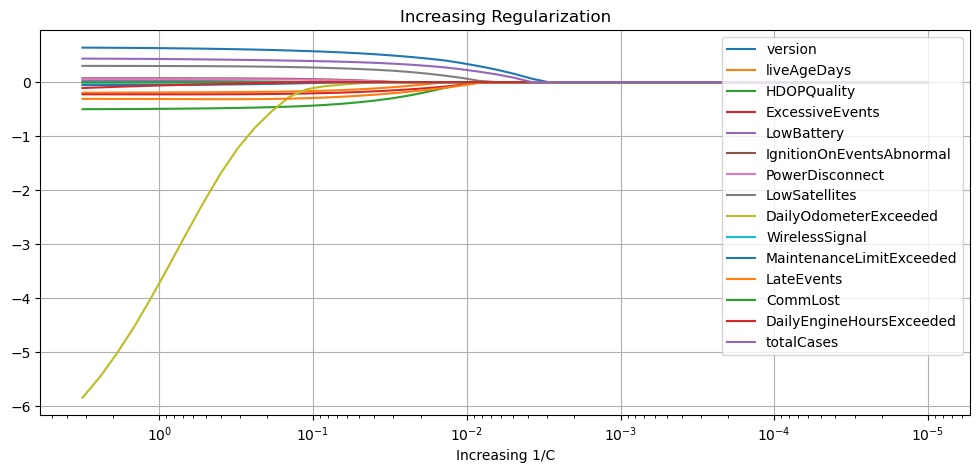

In [55]:
plt.figure(figsize = (12, 5))
plt.semilogx(coef_df)
plt.gca().invert_xaxis()
plt.grid()
plt.legend(list(coef_df.columns), loc='upper right');
plt.title('Increasing Regularization')
plt.xlabel("Increasing 1/C")


#### Selecting most relevant features

In [57]:
selector = SelectFromModel(LogisticRegression(C = 0.1, penalty = 'l1', solver = 'liblinear', random_state = 42))
selector.fit_transform(X_scaled, y)
features = selector.get_feature_names_out(X.columns)
print(features)

['version' 'liveAgeDays' 'HDOPQuality' 'ExcessiveEvents'
 'IgnitionOnEventsAbnormal' 'PowerDisconnect' 'LowSatellites'
 'DailyOdometerExceeded' 'WirelessSignal' 'MaintenanceLimitExceeded'
 'LateEvents' 'totalCases']


### Working with the most relevant features

In [59]:
X = df_l1[features]
X = target_encoder.fit_transform(df_l1['version'], df_l1['isRMA'])
y = df_l1['isRMA']

categories = pd.factorize(y)[1]


# Split data to get Test/Train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.3)

#### One vs. Rest Classification

In [61]:
ovr_lgr = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=42).fit(X_train, y_train)
ovr_probs = ovr_lgr.predict_proba(X_test)
pd.DataFrame(ovr_probs, columns = [categories]).head()

,0,1
0,0.759369,0.240631
1,0.800520,0.199480
2,0.759369,0.240631
3,0.616312,0.383688
4,0.830337,0.169663


#### Multinomial

In [63]:
multi_lgr = LogisticRegression(max_iter=10000, multi_class='multinomial', random_state=42).fit(X_train, y_train)
multi_probs = multi_lgr.predict_proba(X_test)
pd.DataFrame(multi_probs, columns = [categories]).head()

,0,1
0,0.761285,0.238715
1,0.806822,0.193178
2,0.761285,0.238715
3,0.599107,0.400893
4,0.839197,0.160803


#### One vs. One Classifier

In [65]:
ovo_clf = OneVsOneClassifier(LogisticRegression(max_iter=1000, random_state = 42)).fit(X_train, y_train)

#### Comparing Performance

In [67]:
ovr_acc = accuracy_score(y_test, ovr_lgr.predict(X_test))
multi_acc = accuracy_score(y_test, multi_lgr.predict(X_test))
ovo_acc = accuracy_score(y_test, ovo_clf.predict(X_test))

df_performance = pd.DataFrame(
    {
        'estimator': ['ovr', 'multi', 'ovo'], 
        'accuracy': [ovr_acc, multi_acc, ovo_acc]
    }
)

best_acc = df_performance.loc[df_performance['accuracy'].idxmax()]['estimator']
display(best_acc)

display(df_performance.loc[df_performance['accuracy'].idxmax()]['accuracy'])

'ovr'

0.7559748427672957

### Pipeline with Estimator

In [69]:
selector = make_column_selector(dtype_include=object)

transformer = make_column_transformer(
                (OneHotEncoder(handle_unknown='ignore'), selector),
                 remainder = StandardScaler()
        )

extractor = SelectFromModel(
                LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42)
        )


lgr_pipe = Pipeline([
            ('transformer', transformer),
            ('selector', extractor),
            ('lgr', LogisticRegression(random_state=42, max_iter = 1000))
        ])

timestamp = time.time()
lgr_pipe.fit(X_train, y_train)
fitting_time_multiclass = time.time() - timestamp

y_train_pred = lgr_pipe.predict(X_train)
y_test_pred = lgr_pipe.predict(X_test)

train_score_multiclass = accuracy_score(y_train, y_train_pred)
test_score_multiclass = accuracy_score(y_test, y_test_pred)
f1_multiclass = f1_score(y_test, y_test_pred, pos_label = 1)

print(f'train_score_multiclass: {train_score_multiclass}, test_score_multiclass: {test_score_multiclass}, f1_score_multiclass: {f1_multiclass}')

train_score_multiclass: 0.7553995680345572, test_score_multiclass: 0.7559748427672957, f1_score_multiclass: 0.0


#### Confusion Matrix and ROC Curve

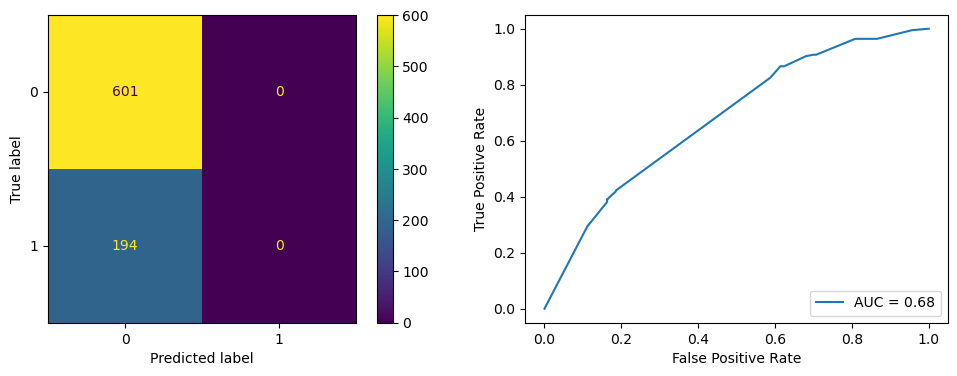

In [71]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

preds = lgr_pipe.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = lgr_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
roc_auc_value = skl_auc(fpr, tpr)

disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

### Applying Oversampling libraries

In [73]:
oversampling = ADASYN(sampling_strategy='not minority')

In [75]:
X_sel = df_l1[features]
y = df['isRMA']

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y, random_state=42, test_size=.3)

In [77]:
selector = make_column_selector(dtype_include=object)

transformer = make_column_transformer(
            (OneHotEncoder(handle_unknown='ignore'), selector),
             remainder = StandardScaler()
        )

extractor = SelectFromModel(
            LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42)
        )


lgr_pipe = PipelineImb([
            ('transformer', transformer),
            ('selector', extractor),
            ('balancing', oversampling),
            ('lgr', LogisticRegression(random_state=42, max_iter = 1000))
        ])

timestamp = time.time()
lgr_pipe.fit(X_train_sel, y_train_sel)
fitting_time_oversampling = time.time() - timestamp

y_train_pred = lgr_pipe.predict(X_train_sel)
y_test_pred = lgr_pipe.predict(X_test_sel)

train_score_oversampling = accuracy_score(y_train_sel, y_train_pred)
test_score_oversampling = accuracy_score(y_test_sel, y_test_pred)
f1_oversampling = f1_score(y_test_sel, y_test_pred, pos_label = 1)

print(f'train_score_oversampling: {train_score_oversampling}, test_score_oversampling: {test_score_oversampling}, f1_score_oversampling: {f1_oversampling}')

train_score_oversampling: 0.7791576673866091, test_score_oversampling: 0.7874213836477988, f1_score_oversampling: 0.3424124513618677


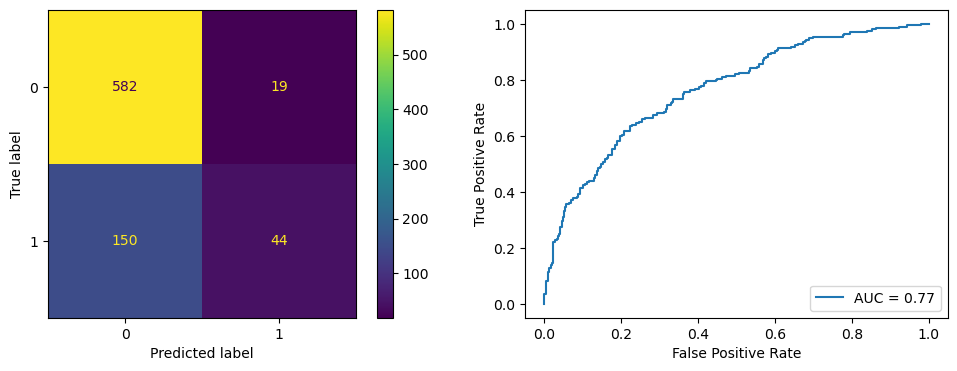

In [79]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

preds = lgr_pipe.predict(X_test_sel)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_sel, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = lgr_pipe.predict_proba(X_test_sel)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_sel, y_score, pos_label=1)
roc_auc_value = skl_auc(fpr, tpr)

disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

### Using GridSearchCV to find best model & hyper params

#### Splitting Data

In [81]:
X = df.drop(['isRMA'], axis=1)
y = df['isRMA']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.3)

#### Reusable methods

In [83]:
def execute_gscv(classifier, param_grid):
    
    selector = make_column_selector(dtype_include=object)
    transformer = make_column_transformer(
            (TargetEncoder(), selector),
             remainder = StandardScaler()
    )
    extractor = SelectFromModel(
            LogisticRegression(penalty='l1', solver = 'liblinear' ,random_state = 42)
    )
    
    # Defining steps
    steps = [
        ('transformer', transformer),
        ('selector', extractor),
        ('classifier', classifier) 
    ]
    
    # Create the pipeline object
    pipeline = Pipeline(steps)
    
    #GridSearchCV to find best hyperparameters
    gscv = GridSearchCV(pipeline, param_grid, scoring = 'accuracy')
    
    timestamp = time.time()
    gscv.fit(X, y)
    fitting_time = time.time() - timestamp
    
    y_train_pred = gscv.best_estimator_.predict(X_train)
    y_test_pred = gscv.best_estimator_.predict(X_test)

    train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, pos_label = 1)
    
    return fitting_time, train_score, test_score, f1, gscv

#### Classifiers & Params

In [85]:
methods_and_params = []

methods_and_params.append({
    'name': 'KNeighborsClassifier', 
    'classifier': KNeighborsClassifier(), 
    'params': {
        'classifier__n_neighbors': [3, 5, 7]  # Hyperparameter for KNeighborsClassifier
    }
})

methods_and_params.append({
    'name': 'LogisticRegression', 
    'classifier': LogisticRegression(random_state=42, max_iter = 1000), 
    'params': {
        'classifier__C': np.logspace(-5, .5)  # Hyperparameter for LogisticRegression
    }
})

methods_and_params.append({
    'name': 'SVC', 
    'classifier': SVC(coef0=1),
    'params': {
        'classifier__kernel': ('linear', 'poly', 'rbf', 'sigmoid'), # Hyperparameter for SVC
        'classifier__degree' : [2,3]  # Hyperparameter for SVC
    }
})

methods_and_params.append({
    'name': 'DecisionTreeClassifier', 
    'classifier': DecisionTreeClassifier(),
    'params': {
        'classifier__max_depth': ['none', 2, 3, 4] # Hyperparameter for DecissionTree
    }
})

#### Executing Classifier

In [87]:
results = []

results.append({
    'name': 'DummyClassifier',
    'fitting_time': fitting_time_dummy,
    'train_score': train_score_dummy, 
    'test_score': test_score_dummy,
    'f1_score': f1_dummy,
    'best_params': ''
})

results.append({
    'name': f'{ best_acc } - multiclass',
    'fitting_time': fitting_time_multiclass,
    'train_score': train_score_multiclass, 
    'test_score': test_score_multiclass,
    'f1_score': f1_multiclass,
    'best_params': ''
})

results.append({
    'name': 'Oversampling',
    'fitting_time': fitting_time_oversampling,
    'train_score': train_score_oversampling, 
    'test_score': test_score_oversampling,
    'f1_score': f1_oversampling,
    'best_params': ''
})


for i, item in enumerate(methods_and_params):
    fitting_time, train_score, test_score, f1, gscv = execute_gscv(item['classifier'], item['params'])
    results.append({
        'name': item['name'],
        'fitting_time': fitting_time,
        'train_score': train_score, 
        'test_score': test_score,
        'f1_score': f1,
        'best_params': gscv.best_params_,
        'gscv': gscv
    })

### Evaluating Results

In [89]:
df_results = pd.DataFrame.from_dict(results).drop(['gscv'], axis=1)
df_results.sort_values(['test_score'], ascending = False)

,name,fitting_time,train_score,test_score,f1_score,best_params
3,KNeighborsClassifier,0.515725,0.849352,0.850314,0.638298,{'classifier__n_neighbors': 7}
6,DecisionTreeClassifier,0.326179,0.797516,0.818868,0.626943,{'classifier__max_depth': 4}
5,SVC,3.317390,0.805076,0.806289,0.373984,"{'classifier__degree': 3, 'classifier__kernel'..."
4,LogisticRegression,5.593816,0.779698,0.793711,0.333333,{'classifier__C': 0.10985411419875572}
2,Oversampling,0.036403,0.779158,0.787421,0.342412,
1,ovr - multiclass,0.016324,0.755400,0.755975,0.000000,
0,DummyClassifier,0.015733,0.505290,0.483384,0.299180,


#### Fitting Time

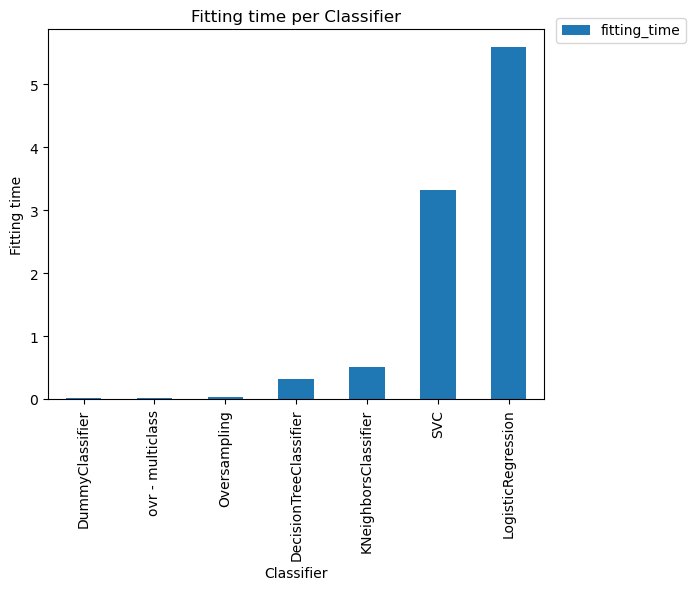

In [91]:
df_results[['name', 'fitting_time']].sort_values('fitting_time', ascending=True).plot(x="name", y="fitting_time", kind="bar")

plt.xlabel("Classifier")
plt.ylabel("Fitting time")
plt.title('Fitting time per Classifier')
plt.legend(bbox_to_anchor=(1.3, 1.05))

#### Test Score & F1

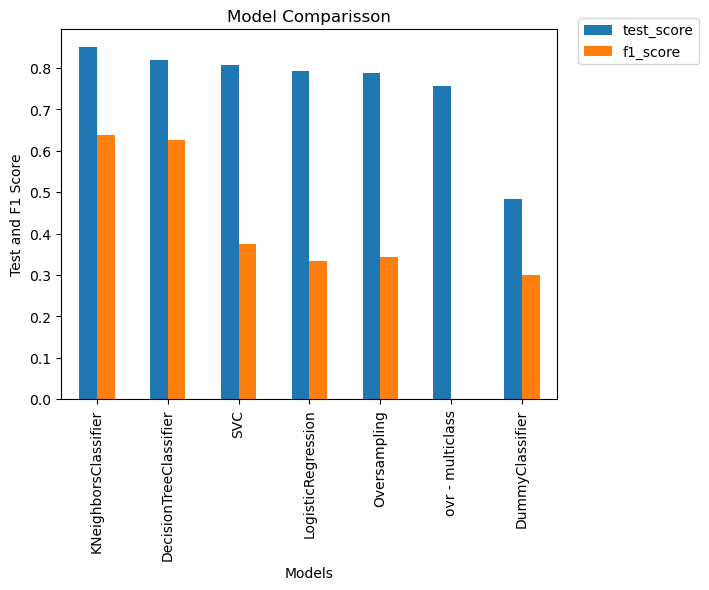

In [93]:
# Plotting the results obtained by executing different regression models. Comparing train mse and test mse
df_results[['name', 'test_score', 'f1_score']].sort_values('test_score', ascending=False).plot(x='name', kind='bar', stacked=False)

plt.xlabel("Models")
plt.ylabel("Test and F1 Score")
plt.title('Model Comparisson')
plt.legend(bbox_to_anchor=(1.3, 1.05))

## Working with the best model

In [95]:
df_results = pd.DataFrame.from_dict(results)

# Get the best model
best_gscv = df_results.loc[df_results['test_score'].idxmax()]['gscv']

display(best_gscv)
display(best_gscv.best_params_)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x318be2f50>)])),
                                       ('selector',
                                        SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                                                     random_state=42,
                                                                                     solver='liblinear'))),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [3, 5, 7]},
             scoring='accuracy')

{'classifier__n_neighbors': 7}

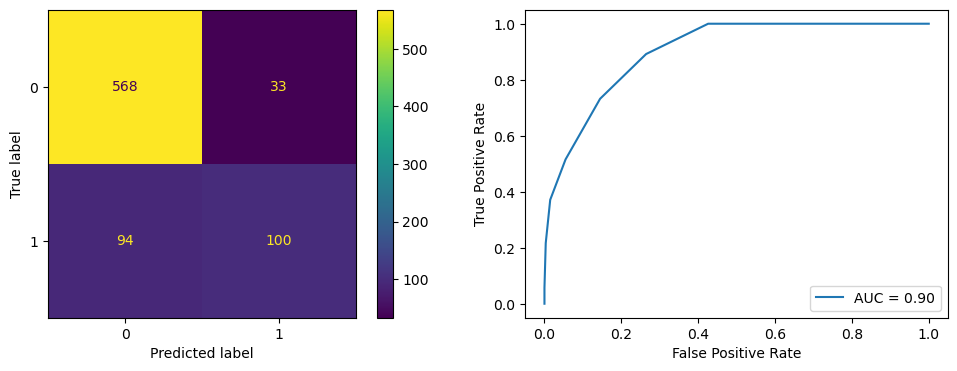

In [97]:
X = df.drop(['isRMA'], axis=1)
y = df['isRMA']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.3)


X_test['version'] = target_encoder.fit_transform(X_test['version'], y_test)
preds = best_gscv.best_estimator_.predict(X_test)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, preds)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = best_gscv.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
roc_auc_value = skl_auc(fpr, tpr)

disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

### Feature Importance

In [99]:
best_classifier = best_gscv.best_estimator_

# Evaluating what are the most important features.
scoring = ['neg_mean_squared_error']

r_multi = permutation_importance(
        best_classifier, 
        X_train, 
        y_train, 
        n_repeats = 10, 
        random_state=42,
        scoring=scoring
)

In [100]:
# Improving the resulting data obtained by generating a sorted DataFrame with importance
importances_tr = dict(
        zip(
                X_train.columns, 
                r_multi['neg_mean_squared_error'].importances_mean
        )
)
importances_tr = {k : v for k ,v in sorted(importances_tr.items(), key = lambda x: x[1], reverse = True)}
import_df = pd.DataFrame(importances_tr.values(), index=importances_tr.keys(), columns = ['Importances'])
display(import_df)

,Importances
liveAgeDays,0.089687
HDOPQuality,0.089147
IgnitionOnEventsAbnormal,0.044870
totalCases,0.035529
ExcessiveEvents,0.030508
LowSatellites,0.023758
LateEvents,0.015767
version,0.005886
PowerDisconnect,0.004536
CommLost,0.001242


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'liveAgeDays'),
  Text(1, 0, 'HDOPQuality'),
  Text(2, 0, 'IgnitionOnEventsAbnormal'),
  Text(3, 0, 'totalCases'),
  Text(4, 0, 'ExcessiveEvents'),
  Text(5, 0, 'LowSatellites'),
  Text(6, 0, 'LateEvents'),
  Text(7, 0, 'version'),
  Text(8, 0, 'PowerDisconnect'),
  Text(9, 0, 'CommLost'),
  Text(10, 0, 'LowBattery'),
  Text(11, 0, 'WirelessSignal'),
  Text(12, 0, 'MaintenanceLimitExceeded'),
  Text(13, 0, 'DailyOdometerExceeded'),
  Text(14, 0, 'DailyEngineHoursExceeded')])

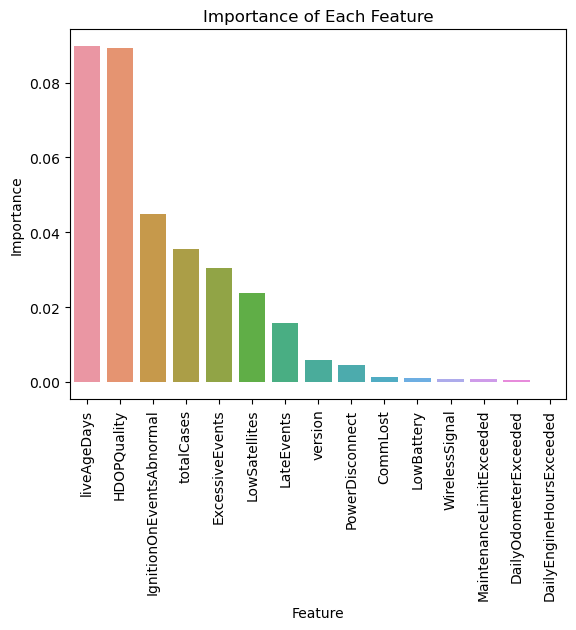

In [103]:
# Visualization of the importance of each feature vs the price
df_importances = import_df.reset_index()

sns.barplot(data = df_importances, x="index", y="Importances")

plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title('Importance of Each Feature')
plt.xticks(rotation=90)  # Rotate labels by 45 degrees

Based on the above graph, the following features are the most important when predicting isRMA (Top 4):

- liveAgeDays
- HDOPQuality
- IgnitionOnEventsAbnormal
- totalCases

The liveAgeDays is an indicator of natural wear and tear of devices. Over time, electronic components, vehicle vibration and other factors can affect GPS device performance. Considering this attribute, the company should review any replacement policies (Warranty) to avoid incurring in extra costs by assuming it.

Devices presenting worse HDOP quality are subject to replacement or installation review. When the GPS signal is not accurate enough, the customer could have a negative experience when tracking vehicle's location. This is a critical factor as shown in the above results.

When the Ignition On/Off appears with high frequency over reports received from devices, this is a negative sign of the device's performance. We could tackle this by evaluating devices where the ignition is NOT detected correctly, firmware with failures over GPS devices and others.

The totalCases column refers to the cases reported by customer when they need to escalate with our internal support team concerning any failure or concern with the device.

### Review most relevant features

#### LiveAgeDays for RMA devices (Mean)

In [127]:
df_graph = df.groupby('isRMA')['liveAgeDays'].mean().reset_index()
df_graph['isRMA'] = np.where(df_graph['isRMA'] == 1 , 'RMA', 'Active')
df_graph

,isRMA,liveAgeDays
0,Active,608.911500
1,RMA,518.982998


Text(0.5, 1.0, 'RMA devices - Live Age Days')

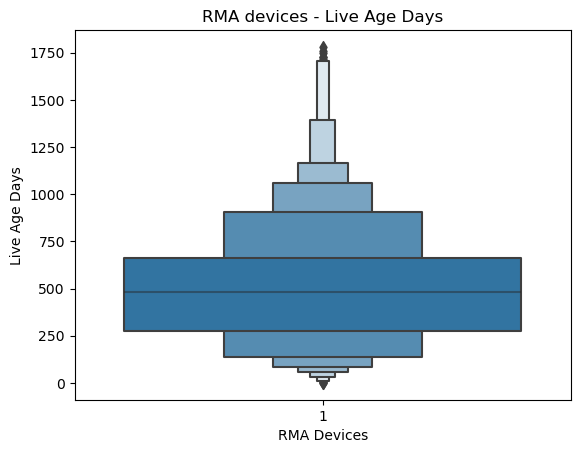

In [125]:
# Review the cuantiles dsitribution for RMA devices using live age days
sns.boxenplot(
	data=df.query('isRMA == 1'), 
	x="isRMA", 
	y="liveAgeDays"
)
plt.xlabel("RMA Devices")
plt.ylabel("Live Age Days")
plt.title('RMA devices - Live Age Days')

#### Top 4 Most relevant Features

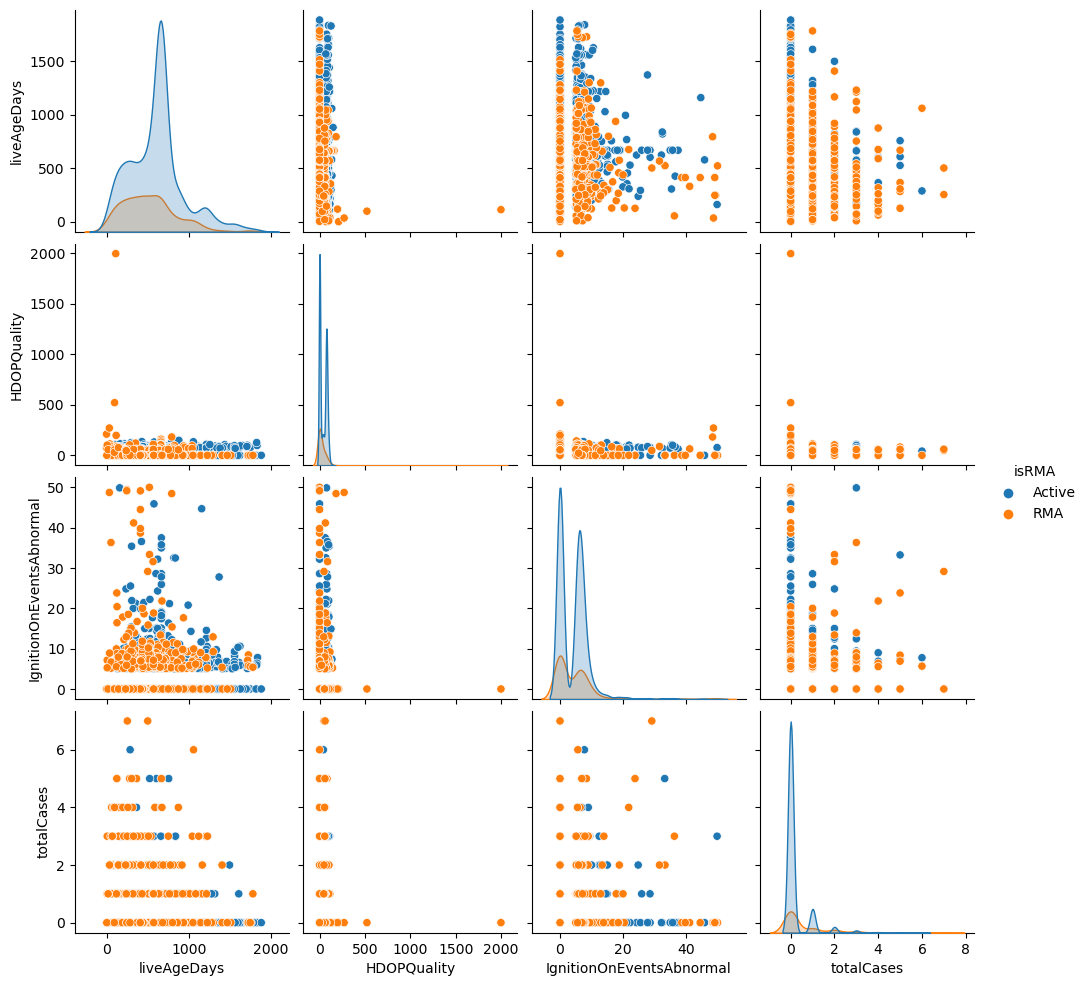

In [107]:
df_graph = df[['liveAgeDays', 
                'HDOPQuality', 
                'IgnitionOnEventsAbnormal',
                'totalCases',
                # 'ExcessiveEvents',
                # 'LowSatellites',
                # 'LateEvents',
                # 'version',
                'isRMA']]

df_graph['isRMA'] = np.where(df_graph['isRMA'] == 1 , 'RMA', 'Active')
sns.pairplot(df_graph, hue = "isRMA")

#### What is the average live age in days per device version?

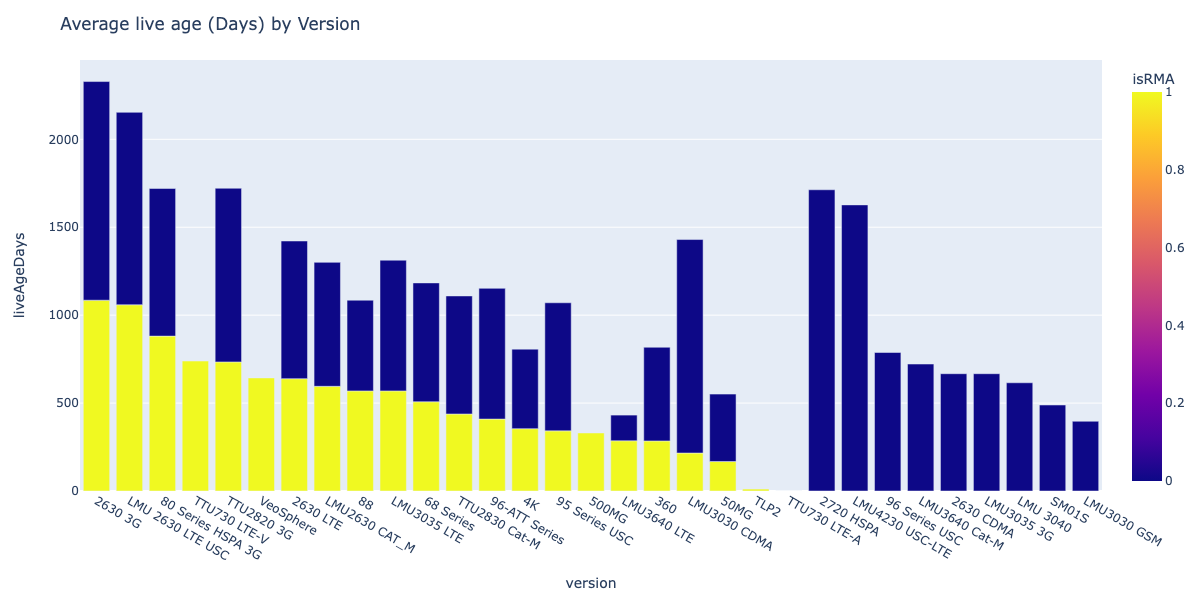

In [192]:
df_graph = df.groupby(['version', 'isRMA'])['liveAgeDays'].mean().reset_index()
df_graph = df_graph.sort_values(['isRMA', 'liveAgeDays'], ascending=False)
fig = px.bar(
        df_graph, 
        x='version', 
        y='liveAgeDays',
        color='isRMA',
        height=400
)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title="Average live age (Days) by Version"
)
fig.show()

Devices version labeled as `2630 3G` is the most durable device in the GPS platform. Meanwhile the `TLP2` and `50MG` a lowest benefit for the company as the rate of live age (TTL) is lower meaning the failures are raising quickly once devices are installed. It is important for the company to make sure are using devices with lower or non rate of TTL. 

#### What is the model with worse HDOPQuality?

Text(0.5, 1.0, 'Average HDOPQuality vs device version')

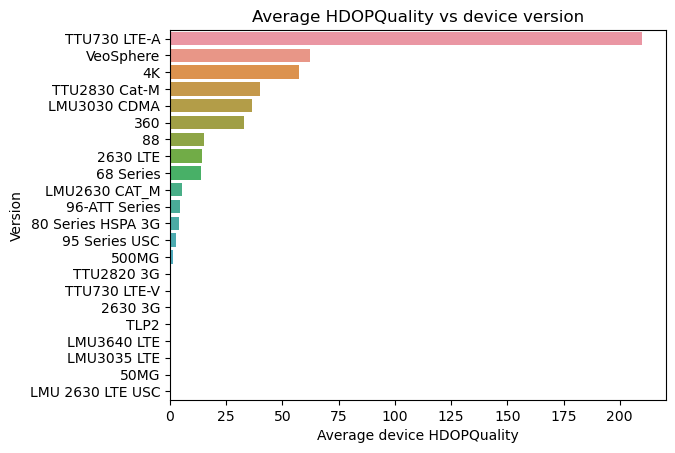

In [195]:
df_graph = df.query('isRMA == 1').groupby('version')['HDOPQuality'].mean().reset_index()
df_graph = df_graph.sort_values('HDOPQuality', ascending=False)
sns.barplot(data = df_graph, x="HDOPQuality", y="version")

plt.xlabel("Average device HDOPQuality")
plt.ylabel("Version")
plt.title('Average HDOPQuality vs device version')

Based on the above graph the `TTU730 LTE A` presents the worse HDOP quality. This should be considered to use an alternative option of hardware as replacement for this version on replacements and new sales in order to avoid unpleasant customer experiences.

#### What is the model with major reported cases?

Text(0.5, 1.0, 'TotalCases vs device version')

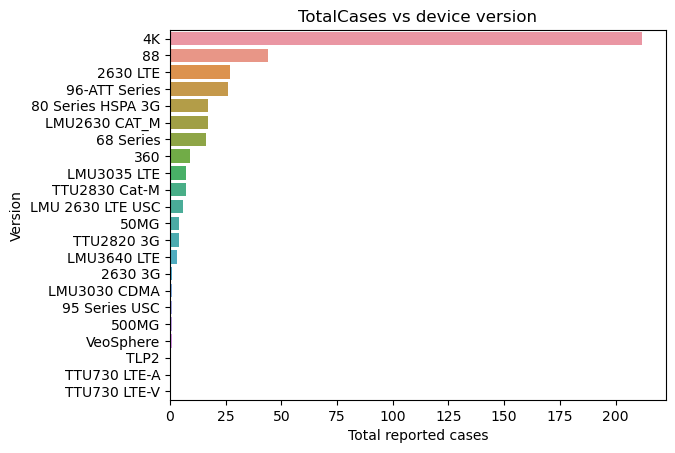

In [139]:
df_graph = df.query('isRMA == 1').groupby('version')['totalCases'].agg(sum).reset_index()
df_graph = df_graph.sort_values('totalCases', ascending=False)
sns.barplot(data = df_graph, x="totalCases", y="version")

plt.xlabel("Total reported cases")
plt.ylabel("Version")
plt.title('TotalCases vs device version')

The `4K` version is the model of devices getting major number of cases reportes through "Sales Force" followed by `88` series. The first one was identified as a recent implementation justifying the amount of cases that could be related to customer and internal trainings over the new version. 

#### What is the model presenting higher IgnitionOnEventsAbnormal?

Text(0.5, 1.0, 'Abnormal IgnitionOnEvents vs device version')

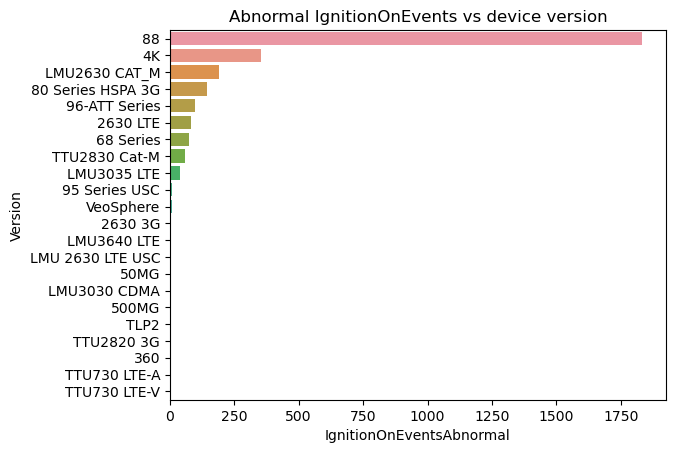

In [181]:
df_graph = df.query('isRMA == 1').groupby('version')['IgnitionOnEventsAbnormal'].agg(sum).reset_index()
df_graph = df_graph.sort_values('IgnitionOnEventsAbnormal', ascending=False)
sns.barplot(data = df_graph, x="IgnitionOnEventsAbnormal", y="version")

plt.xlabel("IgnitionOnEventsAbnormal")
plt.ylabel("Version")
plt.title('Abnormal IgnitionOnEvents vs device version')

The `88` series presents the major number of abnormal IgnitionOn events with a high difference vs the next version (`4K`). This is relevant for customer's experience devices must be correctly installed and reporting correctly the Ignition On/Off events. This is suggested to revisit the installation procedure for `88` version and/or consider an alternative GPS device with similar capabilities.